Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout,BatchNormalization
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
## Mount Google Drive :
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [ ]:
# Image count train and test
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

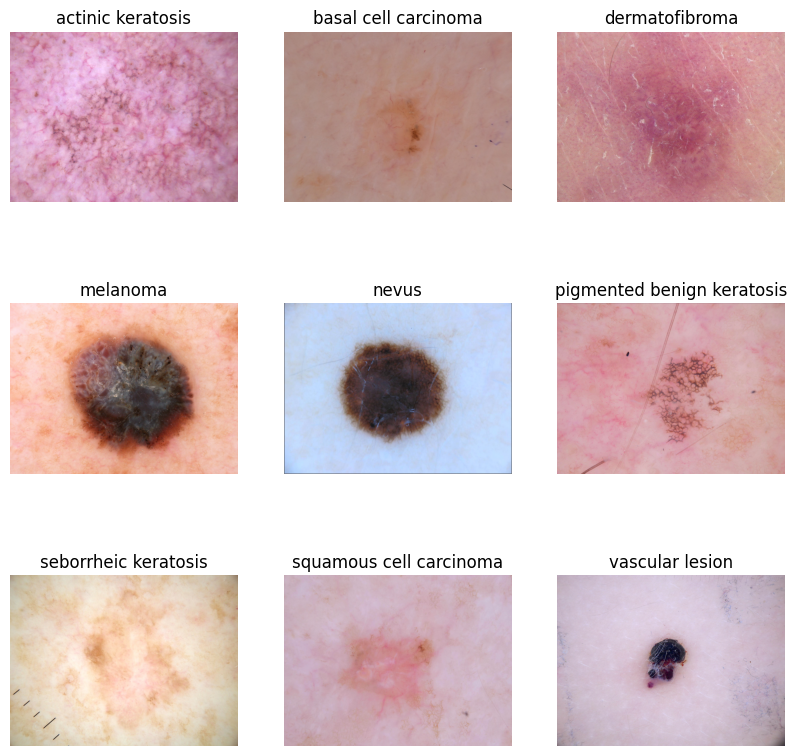

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  image = plt.imread(
      str(list(data_dir_train.glob(f'{class_names[i]}/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
  plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(16, kernel_size=(7, 7),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(11,11),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 16)          │          50,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 5, 5, 128)           │         247,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 2, 2, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 720,601 (2.75 MB)

 Trainable params: 720,601 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 699s 3s/step - accuracy: 0.1756 - loss: 2.0875 - val_accuracy: 0.1924 - val_loss: 2.0277 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.1959 - loss: 2.0263 - val_accuracy: 0.1924 - val_loss: 2.0299 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.2195 - loss: 2.0091 - val_accuracy: 0.2103 - val_loss: 2.0258 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.2076 - loss: 1.9963 - val_accuracy: 0.3266 - val_loss: 1.8393 - learning_rate: 0.0010
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.2910 - loss: 1.8468 - val_accuracy: 0.2975 - val_loss: 1.7418 - learning_rate: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.3434 - loss: 1.7372 - val_accuracy: 0.3244 - val_loss: 1.8888 - learning_rate: 0.0010
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.3585 - loss: 1.7670 - val_acc

### Visualizing training results

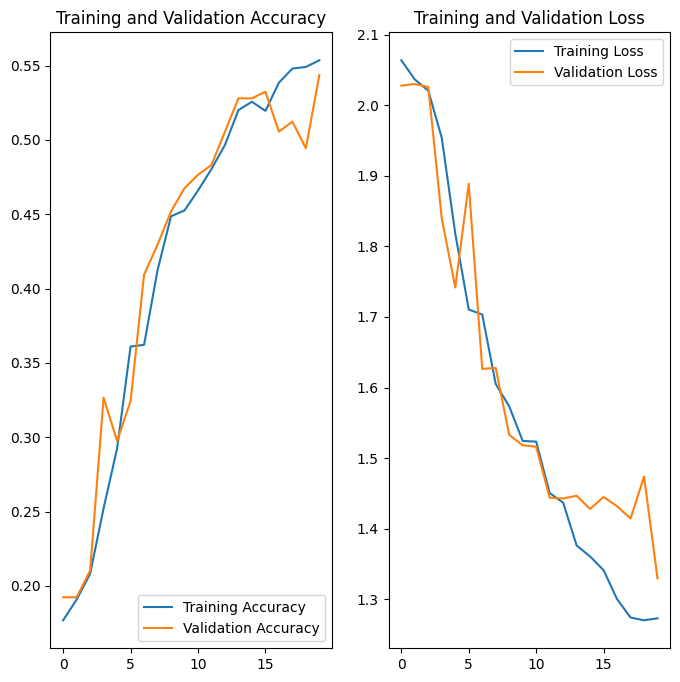

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### **Findings**
-  Training and validation accuracy is very low showing underfitting.
-  Training and validation loss is also very low.

### **Conclusion**
- Model is not good

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augmentation = tf.keras.Sequential(
  [
    keras.layers.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.2),
    keras.layers.RandomContrast(0.1)
  ]
)

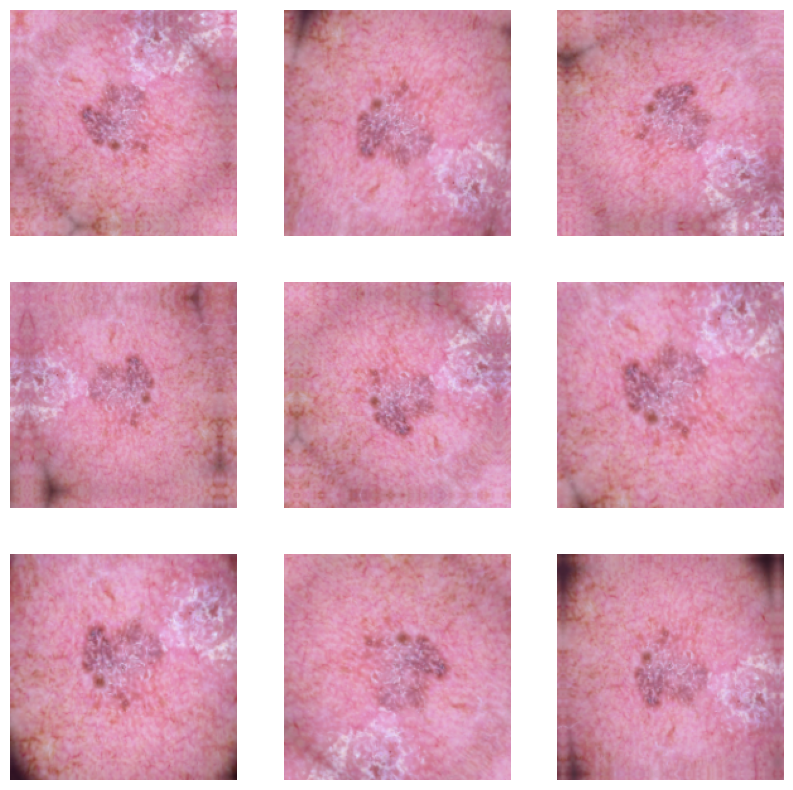

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential()

model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(data_augmentation)
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(16, kernel_size=(7, 7),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(11, 11),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))



### Compiling the model

In [ ]:
### Todo, choose an appropirate optimiser and loss function
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 45, 45, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 22, 22, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 11, 11, 16)          │          50,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 5, 5, 128)           │         247,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 2, 2, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 720,601 (2.75 MB)

 Trainable params: 720,601 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.1625 - loss: 2.1078 - val_accuracy: 0.1924 - val_loss: 2.0765 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.1857 - loss: 2.0570 - val_accuracy: 0.2058 - val_loss: 2.0300 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.1988 - loss: 2.0182 - val_accuracy: 0.1924 - val_loss: 2.0150 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.2466 - loss: 1.9775 - val_accuracy: 0.3490 - val_loss: 1.7653 - learning_rate: 0.0010
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.3356 - loss: 1.7818 - val_accuracy: 0.3244 - val_loss: 1.7204 - learning_rate: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.3052 - loss: 1.7379 - val_accuracy: 0.3915 - val_loss: 1.6924 - learning_rate: 0.0010
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.3610 - loss: 1.6599 - val_ac

### Visualizing the results

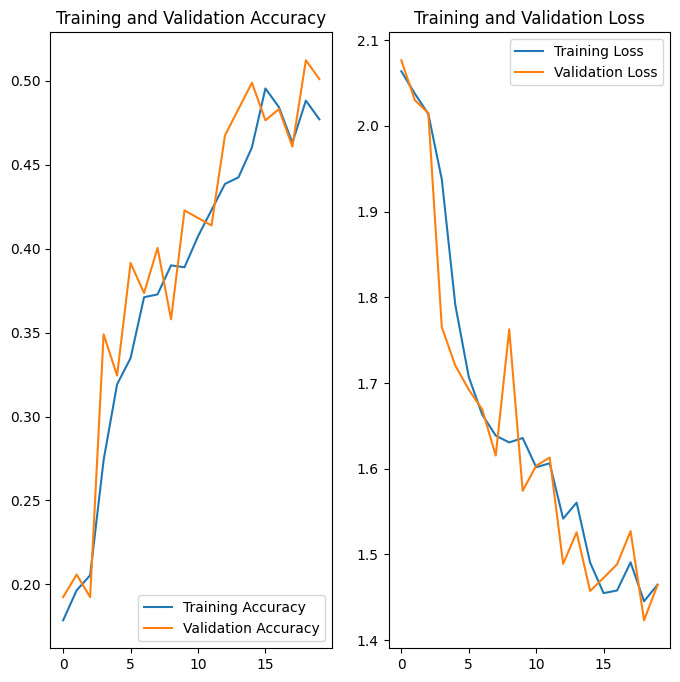

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

### **Findings**
- Training and validation accuracy is still very low but looks similar.

### **Conclusion**
- We need more no of epochs and need to handle class imbalance.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
# images in each classes
class_diff_data=[]
for i in range(len(class_names)):
  name= class_names[i]
  number = len(list(data_dir_train.glob(f'{class_names[i]}/*.jpg')))
  class_diff_data.append({'class':name,'number':number})
class_diff = pd.DataFrame(class_diff_data)

class_diff

,class,number
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


<function matplotlib.pyplot.show(close=None, block=None)>

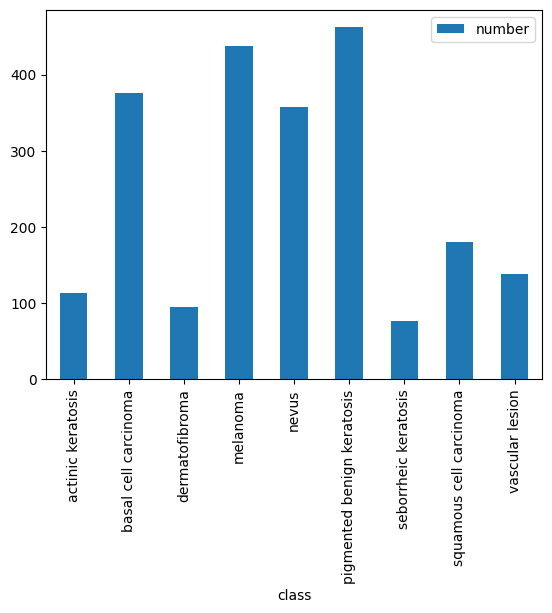

In [ ]:
class_diff.plot.bar(x='class',y='number',rot=90)
plt.show

#### **Findings**
#### - Seborrheic keratosis (77) class has the least number of samples
#### - Pigmented benign keratosis (462) classe dominate the data in terms proportionate number of samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
class_names=['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

In [ ]:
path_to_training_dataset="/content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78F576D4B550>: 100%|██████████| 500/500 [00:22<00:00, 22.66 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78F5AE52E980>: 100%|██████████| 500/500 [00:23<00:00, 21.33 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78F5FA704B50>: 100%|██████████| 500/500 [00:20<00:00, 24.35 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78F576F5F190>: 100%|██████████| 500/500 [01:42<00:00,  4.87 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=576x768 at 0x78F576F0CDF0>: 100%|██████████| 500/500 [01:26<00:00,  5.76 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78F576D48A00>: 100%|██████████| 500/500 [00:21<00:00, 23.71 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x78F576F26EC0>: 100%|██████████| 500/500 [00:42<00:00, 11.63 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78F576F43130>: 100%|██████████| 500/500 [00:19<00:00, 25.12 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78F576517580>: 100%|██████████| 500/500 [00:21<00:00, 22.79 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
# Image count after using Augmentor
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
from glob import glob

path_list_new = list(glob(os.path.join(data_dir_train, '*','output', '*.jpg')))
path_list_new

['/content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026729.jpg_033f586b-2080-4692-aca4-cd74856da0b0.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030143.jpg_f952fe00-120c-4f6d-a79b-288d49513f91.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026848.jpg_68770cae-0275-4c86-aa7e-793a68a09f9b.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028063.jpg_c562599e-e2fe-48e6-8d0e-0a291f57446

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
for i in class_names:
    directory ='images/Train'
    directory_out ='images/Train'+'/'+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob(i+'/*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

actinic keratosis has 0 samples.
basal cell carcinoma has 0 samples.
dermatofibroma has 0 samples.
melanoma has 0 samples.
nevus has 0 samples.
pigmented benign keratosis has 0 samples.
seborrheic keratosis has 0 samples.
squamous cell carcinoma has 0 samples.
vascular lesion has 0 samples.


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train="/content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
model = Sequential()
model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(256,kernel_size=(11,11),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(len(class_names),activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
### Todo, choose an appropirate optimiser and loss function
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 10, 10, 256)         │       3,965,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       1,638,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,738,825 (21.89 MB)

 Trainable params: 5,738,825 (21.89 MB)

 Non-trainable params: 0 (0.00 B)

#### **Todo:**  Train your model

In [ ]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 378ms/step - accuracy: 0.1397 - loss: 2.2026 - val_accuracy: 0.1329 - val_loss: 2.1709 - learning_rate: 0.0010
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 326ms/step - accuracy: 0.1777 - loss: 2.1178 - val_accuracy: 0.2235 - val_loss: 1.9740 - learning_rate: 0.0010
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 70s 254ms/step - accuracy: 0.2308 - loss: 1.9175 - val_accuracy: 0.3408 - val_loss: 1.6716 - learning_rate: 0.0010
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 247ms/step - accuracy: 0.3196 - loss: 1.7599 - val_accuracy: 0.3950 - val_loss: 1.5304 - learning_rate: 0.0010
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 85s 267ms/step - accuracy: 0.3586 - loss: 1.6211 - val_accuracy: 0.3912 - val_loss: 1.5671 - learning_rate: 0.0010
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 77s 240ms/step - accuracy: 0.3874 - loss: 1.5361 - val_accuracy: 0.4529 - val_loss: 1.3988 - learning_rate: 0.0010
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 265ms/step - accuracy: 0.3

#### **Todo:**  Visualize the model results

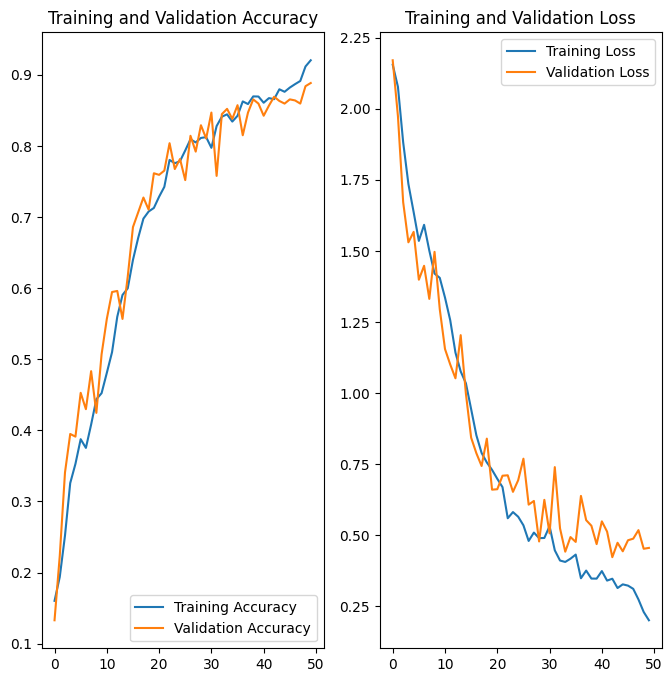

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



### **Findings**
- Training and Validation accuracy almost is same (Difference is within +-5%)
- Also Training and Validation loss is almost same
- Training Accuracy after 50 Epochs and using Augmentor is 91.79%
- Validation Accuracy after 50 Epochs and using Augmentor is 88.86%

### **Conclusion**
- There is no Overfitting/Underfitting in data
- Class imbalance helped to improve accuracy and to handled Overfitting/Underfitting
- By seeing Training and Validation accuracy we can say that model is good fit

### **Test the model**

### **Test-1**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Actual Class: basal cell carcinoma
Predictive Class: basal cell carcinoma


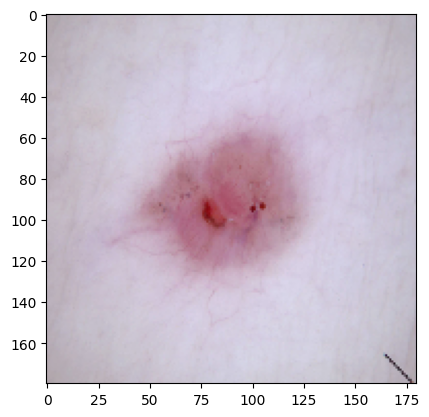

In [ ]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-5],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print(f"Actual Class: {class_names[1]}" + '\n' + "Predictive Class: " + pred_class)

### **Test-2**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Actual Class: basal cell carcinoma
Predictive Class: basal cell carcinoma


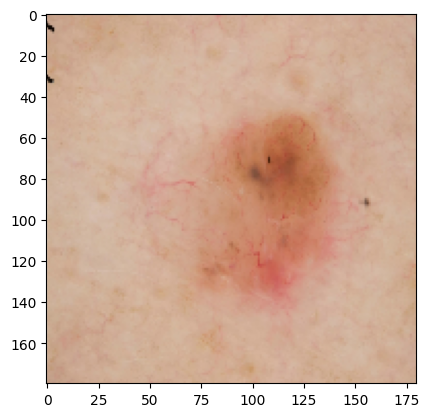

In [ ]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-7],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print(f"Actual Class: {class_names[1]}" + '\n' + "Predictive Class: " + pred_class)

### **Test-3**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Actual Class: basal cell carcinoma
Predictive Class: basal cell carcinoma


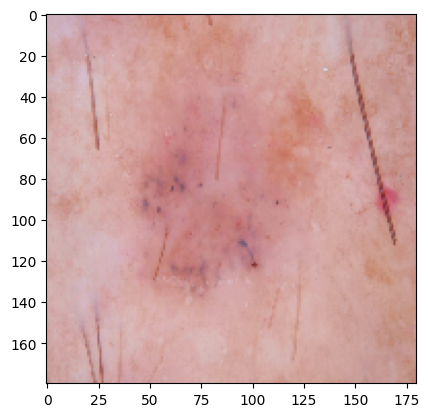

In [ ]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-0],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print(f"Actual Class: {class_names[1]}" + '\n' + "Predictive Class: " + pred_class)

# End